In [1]:
# Imports & Packages
import numpy as np
import pandas as pd
import os
import re

import time, random
from tabulate import tabulate
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

pd.set_option('display.max_columns', None)

data = pd.read_excel("C:/Users/VladislavManolo/project/data/PerformanceData/VC_10M_before_2019_all.xlsx")

data.drop(columns = ['ASSET CLASS', 'RVPI (%)', 'DPI (%)', 'NET IRR (%)', 'CALLED (%)', 'FIRM ID', 'STRATEGY', 'FINAL CLOSE SIZE (USD MN)', 'STATUS',
                   'CORE INDUSTRIES', 'MEDIAN BENCHMARK NET IRR (%)', 'PREQIN QUARTILE RANK', 'QUARTILE RANK',
                   'MEDIAN BENCHMARK NET MULTIPLE (X)', 'WEIGHTED BENCHMARK NET IRR (%)', 'WEIGHTED BENCHMARK NET MULTIPLE (X)',
                   'FUND CURRENCY', 'FUND SIZE (USD MN)', 'FUND SERIES NAME', 'FUND STRUCTURE', 'PRIMARY REGION FOCUS',
                   'FUND AUM (USD MN)', 'FUND DRY POWDER (USD MN)', 'FUND UNREALIZED VALUE (USD MN)',
                   'FUND LEGAL STRUCTURE', 'REGION', 'ADDRESS', 'CITY', 'ZIP CODE', 'TEL', 'EMAIL', 'WEBSITE', 'FUND MANAGER TOTAL AUM (USD MN)'],
          inplace = True)

data.rename(columns = {'NET MULTIPLE (X)': 'MOIC', 'VINTAGE / INCEPTION YEAR': 'Vintage'}, inplace = True)

data.dropna(subset = ['MOIC'], inplace = True)
columns_to_round = ['MOIC']
data[columns_to_round] = data[columns_to_round].round(2)

columns_to_int = ['FUND NUMBER (SERIES)', 'FUND NUMBER (OVERALL)']
data[columns_to_int] = data[columns_to_int].apply(lambda x: pd.to_numeric(x, errors='coerce')).astype('Int64')

data.loc[data['MOIC'] == 0, 'MOIC'] = 0.0001
print(len(data))

2677


In [2]:
fund_manager_counts = data['FUND MANAGER'].value_counts()

emerging_fund_managers = data[data.groupby('FUND MANAGER')['NAME'].transform('count').between(1, 2)].copy()
developing_fund_managers = data[data.groupby('FUND MANAGER')['NAME'].transform('count').between(3, 4)].copy()
established_fund_managers = data[data.groupby('FUND MANAGER')['NAME'].transform('count') >= 5].copy()

def detect_emerging_fund_managers(text):
    return text.endswith(' I') or text.endswith(' II') or text.endswith (' 1') or text.endswith (' 2') or text.endswith (' One') or text.endswith (' Two') or text.endswith ('No.1') or text.endswith ('No.2')

def detect_developing_fund_managers(text):
    return text.endswith(' III') or text.endswith(' IV') or text.endswith(' 3') or text.endswith(' 4') or text.endswith ('No.3') or text.endswith ('No.4')

def detect_established_fund_managers(text):
    return text.endswith(' V') or text.endswith(' VI') or text.endswith(' VII') or text.endswith(' VIII') or text.endswith(' IX') or text.endswith(' X') or text.endswith (' 5') or text.endswith (' 6') or text.endswith (' 7') or text.endswith (' 8') or text.endswith (' 9') or text.endswith (' 10') or text.endswith ('No.5') or text.endswith ('No.6')

########################################### Potential Misclassifications as Emerging Fund Managers ###########################################

emerging_fund_managers['Potentially Developing'] = emerging_fund_managers['NAME'].apply(detect_developing_fund_managers)
emerging_fund_managers['Potentially Established'] = emerging_fund_managers['NAME'].apply(detect_established_fund_managers)

# Potentially Misclassified as Emerging Fund Managers
count_potentially_developing = emerging_fund_managers[emerging_fund_managers['Potentially Developing']].shape[0]
print("Potentially Developing Fund Managers in 'emerging_fund_managers': ", count_potentially_developing)

count_potentially_established = emerging_fund_managers[emerging_fund_managers['Potentially Established']].shape[0]
print("Potentially Established Fund Managers in 'emerging_fund_managers': ", count_potentially_established)

funds_potentially_developing_in_emerging_df = emerging_fund_managers[emerging_fund_managers['Potentially Developing']]
funds_potentially_established_in_emerging_df = emerging_fund_managers[emerging_fund_managers['Potentially Established']]

# Remove these funds from emerging_fund_managers
emerging_fund_managers = emerging_fund_managers[~emerging_fund_managers.index.isin(funds_potentially_developing_in_emerging_df.index)]
emerging_fund_managers = emerging_fund_managers[~emerging_fund_managers.index.isin(funds_potentially_established_in_emerging_df.index)]

########################################### Potential Misclassifications as Developing Fund Managers ###########################################

developing_fund_managers['Potentially Emerging'] = developing_fund_managers['NAME'].apply(detect_emerging_fund_managers)
developing_fund_managers['Potentially Established'] = developing_fund_managers['NAME'].apply(detect_established_fund_managers)

# Potentially Misclassified as Developing Fund Managers
count_potentially_emerging_in_developing_df = developing_fund_managers[developing_fund_managers['Potentially Emerging']].shape[0]
print("Potentially Emerging Fund Managers in 'developing_fund_managers': ", count_potentially_emerging_in_developing_df)

count_potentially_established_in_developing_df = developing_fund_managers[developing_fund_managers['Potentially Established']].shape[0]
print("Potentially Established Fund Managers in 'developing_fund_managers': ", count_potentially_established_in_developing_df)

funds_potentially_emerging_in_developing_df = developing_fund_managers[developing_fund_managers['Potentially Emerging']]
funds_potentially_established_in_developing_df = developing_fund_managers[developing_fund_managers['Potentially Established']]

# Remove these funds from developing_fund_managers
developing_fund_managers = developing_fund_managers[~developing_fund_managers.index.isin(funds_potentially_emerging_in_developing_df.index)]
developing_fund_managers = developing_fund_managers[~developing_fund_managers.index.isin(funds_potentially_established_in_developing_df.index)]

########################################### Potential Misclassifications as Established Fund Managers ###########################################

established_fund_managers['Potentially Emerging'] = established_fund_managers['NAME'].apply(detect_emerging_fund_managers)
established_fund_managers['Potentially Developing'] = established_fund_managers['NAME'].apply(detect_developing_fund_managers)

# Potentially Misclassified as Established Fund Managers
count_potentially_emerging_in_established_df = established_fund_managers[established_fund_managers['Potentially Emerging']].shape[0]
print("Potentially Emerging Fund Managers in 'established_fund_managers': ", count_potentially_emerging_in_established_df)

count_potentially_developing_in_established_df = established_fund_managers[established_fund_managers['Potentially Developing']].shape[0]
print("Potentially Developing Fund Managers in 'established_fund_managers': ", count_potentially_developing_in_established_df)

funds_potentially_emerging_in_established_df = established_fund_managers[established_fund_managers['Potentially Emerging']]
funds_potentially_developing_in_established_df = established_fund_managers[established_fund_managers['Potentially Developing']]

# Remove these funds from established_fund_managers
established_fund_managers = established_fund_managers[~established_fund_managers.index.isin(funds_potentially_emerging_in_established_df.index)]
established_fund_managers = established_fund_managers[~established_fund_managers.index.isin(funds_potentially_developing_in_established_df.index)]

#############################################################################################################################################

# Fixing the dataframes
emerging_fund_managers = pd.concat([emerging_fund_managers, funds_potentially_emerging_in_developing_df])
emerging_fund_managers = pd.concat([emerging_fund_managers, funds_potentially_emerging_in_established_df])

developing_fund_managers = pd.concat([developing_fund_managers, funds_potentially_developing_in_emerging_df])
developing_fund_managers = pd.concat([developing_fund_managers, funds_potentially_developing_in_established_df])

established_fund_managers = pd.concat([established_fund_managers, funds_potentially_established_in_emerging_df])
established_fund_managers = pd.concat([established_fund_managers, funds_potentially_established_in_developing_df])

emerging_fund_managers.drop(columns = ['Potentially Developing', 'Potentially Emerging', 'Potentially Established'], inplace = True)
developing_fund_managers.drop(columns = ['Potentially Developing', 'Potentially Emerging', 'Potentially Established'], inplace = True)
established_fund_managers.drop(columns = ['Potentially Developing', 'Potentially Emerging', 'Potentially Established'], inplace = True)

Potentially Developing Fund Managers in 'emerging_fund_managers':  125
Potentially Established Fund Managers in 'emerging_fund_managers':  35
Potentially Emerging Fund Managers in 'developing_fund_managers':  234
Potentially Established Fund Managers in 'developing_fund_managers':  72
Potentially Emerging Fund Managers in 'established_fund_managers':  210
Potentially Developing Fund Managers in 'established_fund_managers':  221


In [3]:
print("Funds managed by Emerging Managers: ", len(emerging_fund_managers))
print("Funds managed by Developing Managers: ", len(developing_fund_managers))
print("Funds managed by Established Managers: ", len(established_fund_managers))

emerging_unique_funds = set(emerging_fund_managers['FUND ID'])
established_unique_funds = set(established_fund_managers['FUND ID'])
common_funds = emerging_unique_funds.intersection(established_unique_funds)
print("Common Funds:", len(common_funds))

print(" \n ########################## Dropping NaN values ########################## \n")

emerging_fund_managers.dropna(subset = ['MOIC'], inplace = True)
developing_fund_managers.dropna(subset = ['MOIC'], inplace = True)
established_fund_managers.dropna(subset = ['MOIC'], inplace = True)

print("Funds managed by Emerging Managers: ", len(emerging_fund_managers))
print("Funds managed by Developing Managers: ", len(developing_fund_managers))
print("Funds managed by Established Managers: ", len(established_fund_managers))

Funds managed by Emerging Managers:  1290
Funds managed by Developing Managers:  720
Funds managed by Established Managers:  667
Common Funds: 0
 
 ########################## Dropping NaN values ########################## 

Funds managed by Emerging Managers:  1290
Funds managed by Developing Managers:  720
Funds managed by Established Managers:  667


In [4]:
data['Emerging FM'] = 'No'
data['Developing FM'] = 'No'
data['Established FM'] = 'No'

data.loc[data['FUND ID'].isin(emerging_fund_managers['FUND ID']), 'Emerging FM'] = 'Yes'
data.loc[data['FUND ID'].isin(developing_fund_managers['FUND ID']), 'Developing FM'] = 'Yes'
data.loc[data['FUND ID'].isin(established_fund_managers['FUND ID']), 'Established FM'] = 'Yes'
data.head()

,FUND ID,NAME,Vintage,MOIC,DATE REPORTED,FUND MANAGER,FUND NUMBER (SERIES),FUND NUMBER (OVERALL),Emerging FM,Developing FM,Established FM
0,7776,AMWIN Innovation Fund,1998,5.47,2014-12-31,CHAMP Ventures,1,1,Yes,No,No
1,1241,Matrix Partners V,1998,19.86,2023-09-30,Matrix Partners,5,4,No,No,Yes
2,1301,SOFTBANK Technology Ventures IV,1998,1.25,1998-12-31,Softbank Capital,4,1,No,Yes,No
3,2917,Crescendo I,1995,8.28,2023-09-30,Crescendo Ventures,1,1,Yes,No,No
4,3944,Clearstone Venture Partners I-A,1998,14.70,2012-06-30,Clearstone Venture Partners,1,1,No,Yes,No


In [55]:
print(data['Vintage'].dtype) # originally 'Vintage' is of type int64 and we need to convert it to datetime

int64


In [ ]:
data['Vintage'] = pd.to_datetime(data['Vintage'], format = '%Y')
data.drop(columns = ['Developing FM'], inplace = True)
print(data['Vintage'].dtype)

# New Code

Simulating Portfolios...: 100%|██████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.41portfolio/s]


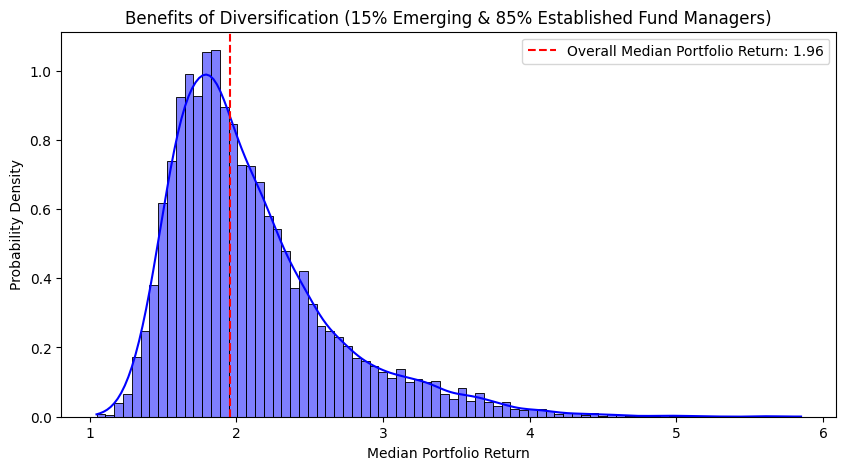

,FUND ID,NAME,Vintage,MOIC,DATE REPORTED,FUND MANAGER,FUND NUMBER (SERIES),FUND NUMBER (OVERALL),Emerging FM,Developing FM,Established FM
2277,2520,TAT Investment Fund II,1999,0.53,2009-12-31,TAT Capital Partners,2,2,Yes,No,No
1726,379,Burrill Life Sciences Capital Fund II,2002,1.22,2023-09-30,Burrill & Company,2,4,Yes,No,No
1760,14335,NGN BioMed Opportunity Fund II,2008,1.31,2023-03-31,NGN Capital,2,2,Yes,No,No
1294,11015,Frazier Healthcare VI,2008,1.50,2022-12-31,Frazier Healthcare Partners,6,7,No,No,Yes
24,1269,Menlo Ventures VII,1997,4.71,2023-09-30,Menlo Ventures,7,6,No,No,Yes
1634,74948,New Science Ventures 2013,2013,1.28,2018-09-30,New Science Ventures,6,9,No,No,Yes
1975,81248,Easo Ventures,2018,0.98,2023-06-30,Inveready Asset Management,1,6,No,No,Yes
2886,83238,Hangzhou Deyu Investment Partnership Enterprise,2017,0.54,2021-06-30,Detong Capital,1,21,No,No,Yes
1019,15550,Adams Street 2008 Direct Fund,2008,2.64,2023-06-30,Adams Street Partners,7,38,No,No,Yes
1323,13631,Hua VI,2003,1.13,2007-12-31,Vincera Capital,6,4,No,No,Yes


In [6]:
emerging_funds = data[data['Emerging FM'] == 'Yes']
established_funds = data[data['Established FM'] == 'Yes']

def simulate_portfolio_median_returns(data, manager_type, returns_column = 'MOIC', vintage_column = 'Vintage', n_assets = 20, n_portfolios = 10000):  
    
    portfolio_median_performances = []
    
    for _ in tqdm(range(n_portfolios), desc = "Simulating Portfolios...", unit = "portfolio"):

        # each portfolio consists of 3 funds managed by emerging managers & 17 funds managed by established managers
        portfolio_composition = pd.concat([emerging_funds.sample(n = 3, replace = False), established_funds.sample(n = 17, replace = False)])
        
        returns = portfolio_composition.loc[:, 'MOIC']
        
        selected_assets = np.random.choice(returns.index.dropna(), n_assets, replace = False)
        weights = np.ones(n_assets) / n_assets                                      # Equal Weights: 1 / 20 = 0.05 weight per fund
        portfolio_median_return = np.dot(weights.T, returns[selected_assets])       # The median MOIC return of a portfolio
        portfolio_median_performances.append(portfolio_median_return)               # The median MOIC returns of all 1000 portfolios
            
    overall_median_moic_across_1000_portfolios = np.nanmedian(portfolio_median_performances)

    plt.figure(figsize = (10, 5))
    sns.histplot(portfolio_median_performances, kde = True, bins = 80, color = 'blue', stat = 'density', common_norm = False)
    plt.axvline(x = overall_median_moic_across_1000_portfolios, color = 'red', linestyle = '--', label = f'Overall Median Portfolio Return: {overall_median_moic_across_1000_portfolios:.2f}')
    plt.title(f'Benefits of Diversification ({manager_type} Fund Managers)')
    plt.xlabel('Median Portfolio Return')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

simulate_portfolio_median_returns(data, '15% Emerging & 85% Established')

# Monte Carlo Simulations on funds vintaged between the years 2000 and 2019

## Portfolio Composition: 15% Emerging & 85% Established

In [ ]:
post_2000_data = data[data['Vintage'] >= 2000].copy()

emerging_funds = post_2000_data[post_2000_data['Emerging FM'] == 'Yes']
established_funds = post_2000_data[post_2000_data['Established FM'] == 'Yes']

Simulating Portfolios...: 100%|██████████████████████████████████████████| 10000/10000 [01:15<00:00, 132.60portfolio/s]


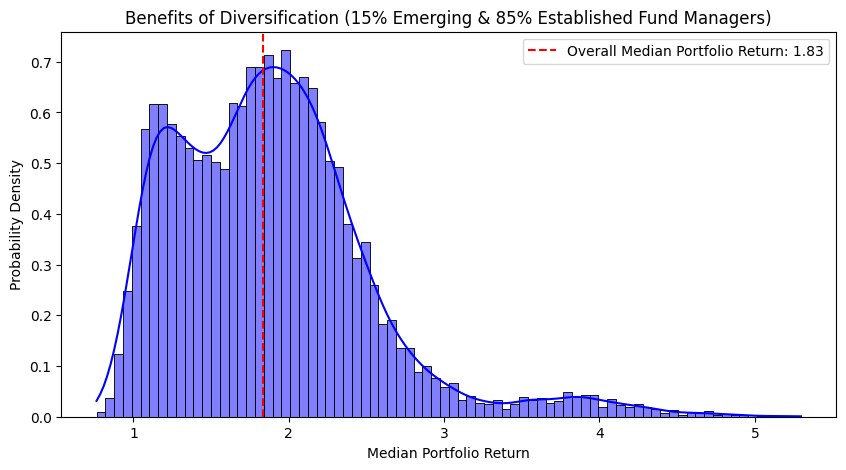

,FUND ID,NAME,Vintage,MOIC,DATE REPORTED,FUND MANAGER,FUND NUMBER (SERIES),FUND NUMBER (OVERALL),Emerging FM,Developing FM,Established FM
949,97162,RCF LC Ventures I,2018,1.25,2022-12-31,LC Ventures,1,3,Yes,No,No
131,79317,Alpha JWC Ventures II,2018,3.39,2022-12-31,Alpha JWC Ventures,2,2,Yes,No,No
302,97602,BY Capital 2,2019,1.23,2021-09-30,BlueYard Capital,2,2,Yes,No,No
1495,33067,A. M. Pappas Life Science Ventures V,2017,1.20,2023-06-30,Pappas Capital,5,6,No,No,Yes
594,75101,Institutional Venture Partners XVI,2018,2.00,2023-03-31,Institutional Venture Partners,10,13,No,No,Yes
1677,52822,500 TukTuks,2017,1.03,2017-03-31,500 Global,1,8,No,No,Yes
832,68531,Upfront VI,2017,1.75,2022-12-31,Upfront Ventures,6,10,No,No,Yes
2395,102672,SV7 Impact Medicine Fund,2019,0.69,2022-12-31,SV Health Investors,7,8,No,No,Yes
1292,93599,Versant Ventures VII,2018,1.26,2023-03-31,Versant Ventures,7,8,No,No,Yes
2515,134814,NEA BH SPV,2019,2.74,2021-06-30,New Enterprise Associates,<NA>,22,No,No,Yes


In [96]:
def simulate_portfolio_median_returns(data, n_emerging_funds, n_established_funds, manager_type, returns_column = 'MOIC', vintage_column = 'Vintage', n_assets = 20, n_portfolios = 10000):  
    
    portfolio_median_performances = []

    for _ in tqdm(range(n_portfolios), desc = "Simulating Portfolios...", unit = "portfolio"):
        selected_emerging = emerging_funds.sample(n = 1, replace = False)

        emerging_vintage_min = max(2000, selected_emerging['Vintage'].min() - 1) # retrieving the min vintage that can be included in the portfolio; We take the max between 2000 and the min vintage - 1. This ensures the min vintage doesn't go below the year 2000. If the calculated min vintage is 2000 or greater, it remains unchanged.
        emerging_vintage_max = selected_emerging['Vintage'].max() + 1 # retrieving the max vintage that can be included in the portfolio

        # Adding additional funds managed by emerging fund managers
        additional_emerging = emerging_funds[
            (emerging_funds['Vintage'] >= emerging_vintage_min) &
            (emerging_funds['Vintage'] <= emerging_vintage_max)
        ].sample(n = n_emerging_funds, replace = False)

        # Adding additional funds managed by established fund managers
        selected_established = established_funds[
            (established_funds['Vintage'] >= emerging_vintage_min) &
            (established_funds['Vintage'] <= emerging_vintage_max)
        ].sample(n = n_established_funds, replace = False)

        # Creating the portfolio
        portfolio_composition = pd.concat([selected_emerging, additional_emerging, selected_established])
    
        returns = portfolio_composition.loc[:, 'MOIC']
        selected_assets = np.random.choice(returns.index.dropna(), n_assets, replace=False)
        weights = np.ones(len(selected_assets)) / len(selected_assets)
    
        try:
            portfolio_median_return = np.dot(weights.T, returns[selected_assets])
            portfolio_median_performances.append(portfolio_median_return)
        except ValueError as e:
            #print(f"Error: {e}. Skipping this portfolio.")
            continue
    
    overall_median_moic_across_1000_portfolios = np.nanmedian(portfolio_median_performances)

    plt.figure(figsize = (10, 5))
    sns.histplot(portfolio_median_performances, kde = True, bins = 80, color = 'blue', stat = 'density', common_norm = False)
    plt.axvline(x = overall_median_moic_across_1000_portfolios, color = 'red', linestyle = '--', label = f'Overall Median Portfolio Return: {overall_median_moic_across_1000_portfolios:.2f}')
    plt.title(f'Benefits of Diversification ({manager_type} Fund Managers)')
    plt.xlabel('Median Portfolio Return')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

    return portfolio_composition

simulate_portfolio_median_returns(data, 2, 17, '15% Emerging & 85% Established')

## Portfolio Composition: 20% Emerging & 80% Established

Simulating Portfolios...: 100%|██████████████████████████████████████████| 10000/10000 [01:16<00:00, 130.04portfolio/s]


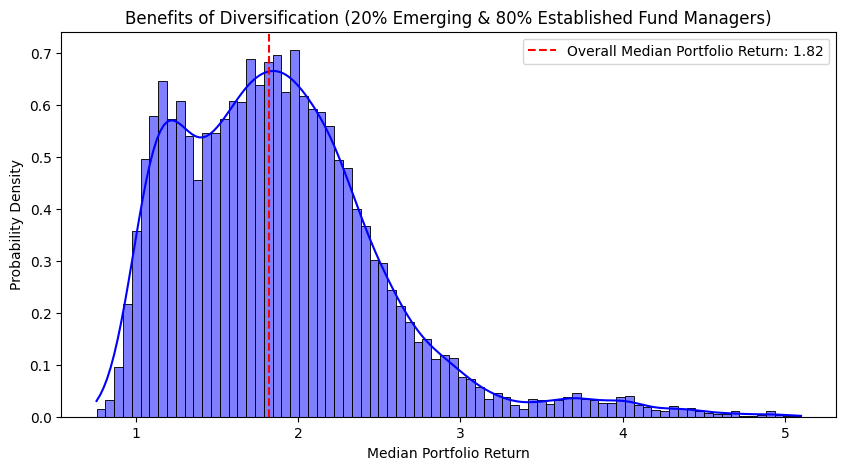

,FUND ID,NAME,Vintage,MOIC,DATE REPORTED,FUND MANAGER,FUND NUMBER (SERIES),FUND NUMBER (OVERALL),Emerging FM,Developing FM,Established FM
1422,495,CID Seed Fund,2000,2.08,2023-09-30,Cambridge Capital Management,1,4,Yes,No,No
1560,13548,Nestor 2000,2000,1.63,2011-03-31,360 Capital,2,1,Yes,No,No
2112,216,Athenian Venture Partners II,2001,0.73,2023-09-30,Athenian Venture Partners,2,2,Yes,No,No
2658,314,Birchmere Ventures II,2000,1.13,2023-09-30,Birchmere Advisors,2,2,Yes,No,No
1413,7471,Sichuan Small Investment Fund,2001,2.16,2014-12-31,SEAF,1,6,No,No,Yes
2762,5585,SEAF-The Central & Eastern European Growth Fund,2000,1.02,2014-12-31,SEAF,1,4,No,No,Yes
2148,2961,Ventures West 7,2000,0.78,2023-09-30,Ventures West Capital,7,5,No,No,Yes
2406,680,Enterprise Partners VI,2001,0.07,2023-09-30,Enterprise Partners Venture Capital,6,4,No,No,Yes
1285,21328,Walden Venture Capital VI,2000,2.19,2015-06-30,Walden Venture Capital,6,1,No,No,Yes
2123,2111,Sanderling Venture V,2000,0.56,2023-03-31,Sanderling Ventures,5,2,No,No,Yes


In [78]:
def simulate_portfolio_median_returns(data, manager_type, returns_column = 'MOIC', vintage_column = 'Vintage', n_assets = 20, n_portfolios = 10000):  
    
    portfolio_median_performances = []

    for _ in tqdm(range(n_portfolios), desc = "Simulating Portfolios...", unit = "portfolio"):
        selected_emerging = emerging_funds.sample(n = 1, replace = False)

        emerging_vintage_min = max(2000, selected_emerging['Vintage'].min() - 1) # retrieving the min vintage that can be included in the portfolio; We take the max between 2000 and the min vintage - 1. This ensures the min vintage doesn't go below the year 2000. If the calculated min vintage is 2000 or greater, it remains unchanged.
        emerging_vintage_max = selected_emerging['Vintage'].max() + 1 # retrieving the max vintage that can be included in the portfolio

        # Adding additional funds managed by emerging fund managers
        additional_emerging = emerging_funds[
            (emerging_funds['Vintage'] >= emerging_vintage_min) &
            (emerging_funds['Vintage'] <= emerging_vintage_max)
        ].sample(n = 3, replace = False)

        # Adding additional funds managed by established fund managers
        selected_established = established_funds[
            (established_funds['Vintage'] >= emerging_vintage_min) &
            (established_funds['Vintage'] <= emerging_vintage_max)
        ].sample(n = 16, replace = False)

        # Creating the portfolio
        portfolio_composition = pd.concat([selected_emerging, additional_emerging, selected_established])
    
        returns = portfolio_composition.loc[:, 'MOIC']
        selected_assets = np.random.choice(returns.index.dropna(), n_assets, replace=False)
        weights = np.ones(len(selected_assets)) / len(selected_assets)
    
        try:
            portfolio_median_return = np.dot(weights.T, returns[selected_assets])
            portfolio_median_performances.append(portfolio_median_return)
        except ValueError as e:
            #print(f"Error: {e}. Skipping this portfolio.")
            continue
    
    overall_median_moic_across_1000_portfolios = np.nanmedian(portfolio_median_performances)

    plt.figure(figsize = (10, 5))
    sns.histplot(portfolio_median_performances, kde = True, bins = 80, color = 'blue', stat = 'density', common_norm = False)
    plt.axvline(x = overall_median_moic_across_1000_portfolios, color = 'red', linestyle = '--', label = f'Overall Median Portfolio Return: {overall_median_moic_across_1000_portfolios:.2f}')
    plt.title(f'Benefits of Diversification ({manager_type} Fund Managers)')
    plt.xlabel('Median Portfolio Return')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

    return portfolio_composition

simulate_portfolio_median_returns(data, '20% Emerging & 80% Established')

Simulating Portfolios...: 100%|████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.76portfolio/s]


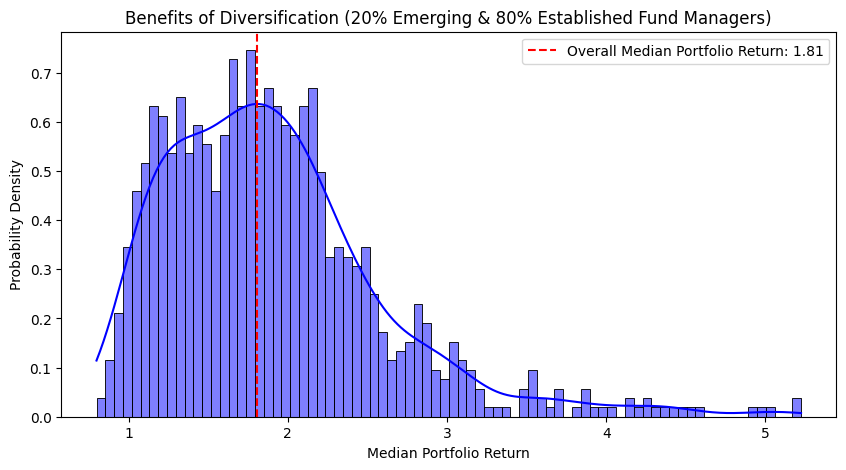

,FUND ID,NAME,Vintage,MOIC,DATE REPORTED,FUND MANAGER,FUND NUMBER (SERIES),FUND NUMBER (OVERALL),Emerging FM,Developing FM,Established FM
1146,74509,Seaya Ventures II,2017,1.66,2023-06-30,Seaya Ventures,2,2,Yes,No,No
597,93149,Peregrine Select Fund I,2018,1.98,2022-06-30,Right Side Capital Management,1,4,Yes,No,No
340,63989,Third Prime Alpha Fund,2017,2.67,2021-03-31,Third Prime Capital,1,1,Yes,No,No
1532,144248,Sands Capital Global Venture Fund II,2018,1.25,2023-06-30,Sands Capital Ventures,2,5,Yes,No,No
492,93787,Suzhou Galaxy Xinji Fund,2018,2.70,2022-09-30,Galaxy Ventures,1,1,Yes,No,No
2493,107835,First:Seed,2018,0.99,2021-03-31,Skagerak Capital,<NA>,<NA>,Yes,No,No
377,109913,Karmel Capital Founders Fund II,2018,1.98,2021-12-31,Karmel Capital,2,2,Yes,No,No
2859,75055,Technology Impact Fund I,2017,1.46,2019-12-31,Capricorn Investment Group,1,1,Yes,No,No
385,119412,SIX FinTech Ventures,2018,0.02,2023-06-30,SIX Fintech Ventures,1,1,Yes,No,No
594,75101,Institutional Venture Partners XVI,2018,2.00,2023-03-31,Institutional Venture Partners,10,13,No,No,Yes


In [91]:
def simulate_portfolio_median_returns(data, n_emerging_funds, n_established_funds, manager_type, returns_column = 'MOIC', vintage_column = 'Vintage', n_assets = 20, n_portfolios = 1000):  
    
    portfolio_median_performances = []

    for _ in tqdm(range(n_portfolios), desc = "Simulating Portfolios...", unit = "portfolio"):
        selected_emerging = emerging_funds.sample(n = 1, replace = False)

        emerging_vintage_min = max(2000, selected_emerging['Vintage'].min() - 1) # retrieving the min vintage that can be included in the portfolio; We take the max between 2000 and the min vintage - 1. This ensures the min vintage doesn't go below the year 2000. If the calculated min vintage is 2000 or greater, it remains unchanged.
        emerging_vintage_max = selected_emerging['Vintage'].max() + 1 # retrieving the max vintage that can be included in the portfolio

        # Adding additional funds managed by emerging fund managers
        additional_emerging = emerging_funds[
            (emerging_funds['Vintage'] >= emerging_vintage_min) &
            (emerging_funds['Vintage'] <= emerging_vintage_max)
        ].sample(n = n_emerging_funds, replace = False)

        # Adding additional funds managed by established fund managers
        selected_established = established_funds[
            (established_funds['Vintage'] >= emerging_vintage_min) &
            (established_funds['Vintage'] <= emerging_vintage_max)
        ].sample(n = n_established_funds, replace = False)

        # Creating the portfolio
        portfolio_composition = pd.concat([selected_emerging, additional_emerging, selected_established])
    
        returns = portfolio_composition.loc[:, 'MOIC']
        selected_assets = np.random.choice(returns.index.dropna(), n_assets, replace=False)
        weights = np.ones(len(selected_assets)) / len(selected_assets)
    
        try:
            portfolio_median_return = np.dot(weights.T, returns[selected_assets])
            portfolio_median_performances.append(portfolio_median_return)
        except ValueError as e:
            #print(f"Error: {e}. Skipping this portfolio.")
            continue
    
    overall_median_moic_across_1000_portfolios = np.nanmedian(portfolio_median_performances)

    plt.figure(figsize = (10, 5))
    sns.histplot(portfolio_median_performances, kde = True, bins = 80, color = 'blue', stat = 'density', common_norm = False)
    plt.axvline(x = overall_median_moic_across_1000_portfolios, color = 'red', linestyle = '--', label = f'Overall Median Portfolio Return: {overall_median_moic_across_1000_portfolios:.2f}')
    plt.title(f'Benefits of Diversification ({manager_type} Fund Managers)')
    plt.xlabel('Median Portfolio Return')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

    return portfolio_composition

simulate_portfolio_median_returns(data, 8, 12, '20% Emerging & 80% Established')

### Examining Portfolios

Simulating Portfolios...: 100%|████████████████████████████████████████████| 1000/1000 [00:08<00:00, 115.23portfolio/s]


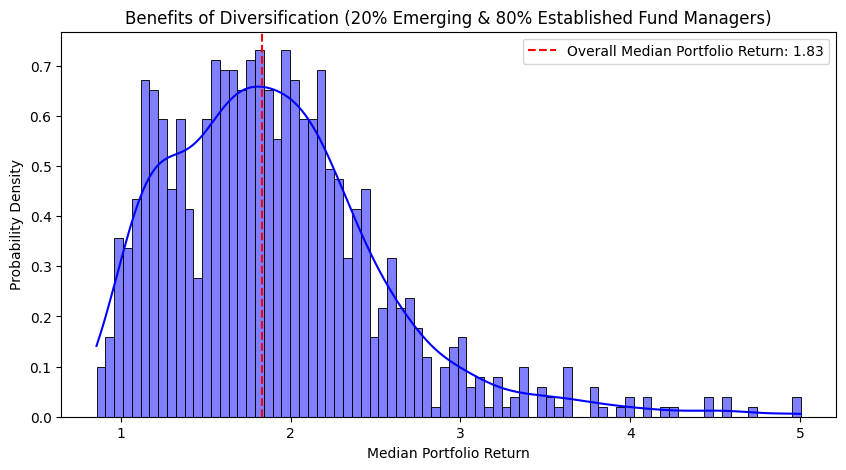

In [89]:
def simulate_portfolio_median_returns(data, manager_type, returns_column='MOIC', vintage_column='Vintage', n_assets=20, n_portfolios=1000):
    portfolio_median_performances = []
    last_three_portfolios = []

    for _ in tqdm(range(n_portfolios), desc="Simulating Portfolios...", unit="portfolio"):
        selected_emerging = emerging_funds.sample(n=1, replace=False)

        emerging_vintage_min = max(2000, selected_emerging['Vintage'].min() - 1)
        emerging_vintage_max = selected_emerging['Vintage'].max() + 1

        additional_emerging = emerging_funds[
            (emerging_funds['Vintage'] >= emerging_vintage_min) &
            (emerging_funds['Vintage'] <= emerging_vintage_max)
        ].sample(n=3, replace=False)

        selected_established = established_funds[
            (established_funds['Vintage'] >= emerging_vintage_min) &
            (established_funds['Vintage'] <= emerging_vintage_max)
        ].sample(n=16, replace=False)

        # Selecting only the specified columns
        portfolio_composition = pd.concat([selected_emerging, additional_emerging, selected_established])[
            ['Vintage', 'MOIC', 'Emerging FM', 'Established FM']
        ]

        returns = portfolio_composition.loc[:, 'MOIC']
        selected_assets = np.random.choice(returns.index.dropna(), n_assets, replace=False)
        weights = np.ones(len(selected_assets)) / len(selected_assets)

        try:
            portfolio_median_return = np.dot(weights.T, returns[selected_assets])
            portfolio_median_performances.append(portfolio_median_return)

            # Store the last three portfolios
            if len(last_three_portfolios) < 3:
                last_three_portfolios.append(portfolio_composition.copy())
            else:
                last_three_portfolios.pop(0)
                last_three_portfolios.append(portfolio_composition.copy())
        except ValueError as e:
            # print(f"Error: {e}. Skipping this portfolio.")
            continue

    overall_median_moic_across_1000_portfolios = np.nanmedian(portfolio_median_performances)

    plt.figure(figsize=(10, 5))
    sns.histplot(portfolio_median_performances, kde=True, bins=80, color='blue', stat='density', common_norm=False)
    plt.axvline(x=overall_median_moic_across_1000_portfolios, color='red', linestyle='--',
                label=f'Overall Median Portfolio Return: {overall_median_moic_across_1000_portfolios:.2f}')
    plt.title(f'Benefits of Diversification ({manager_type} Fund Managers)')
    plt.xlabel('Median Portfolio Return')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

    return last_three_portfolios

last_three_portfolios = simulate_portfolio_median_returns(data, '20% Emerging & 80% Established')

In [90]:
last_three_portfolios

[      Vintage  MOIC Emerging FM Established FM
 1311     2005  1.75         Yes             No
 2421     2005  0.47         Yes             No
 932      2006  1.73         Yes             No
 2709     2004  1.64         Yes             No
 1776     2006  1.07          No            Yes
 650      2006  5.71          No            Yes
 2314     2006  0.33          No            Yes
 1284     2006  1.19          No            Yes
 1675     2005  1.63          No            Yes
 2737     2005  0.85          No            Yes
 1699     2005  1.33          No            Yes
 1735     2006  1.25          No            Yes
 2062     2004  0.78          No            Yes
 1357     2004  1.85          No            Yes
 1758     2004  1.19          No            Yes
 1479     2006  1.35          No            Yes
 2739     2005  1.91          No            Yes
 958      2006  2.55          No            Yes
 2207     2006  0.68          No            Yes
 1454     2006  1.43          No        

# Old Code

In [6]:
def simulate_portfolio_median_returns(data, manager_type, returns_column = 8, vintage_column = 'Vintage', n_assets = 20, n_portfolios = 1000, max_iterations = 50):
    """
    Simulate median returns of portfolios based on specified conditions.

    Parameters:
    - data: DataFrame containing the dataset.
    - returns_column: Column containing the returns data (MOIC).
    - vintage_column: Column containing the vintage information.
    - manager_type: A string indicating the type of fund manager (e.g., 'emerging', 'developing', 'established').
    - n_assets: Number of funds in each portfolio.
    - n_portfolios: Number of portfolios to simulate.
    - max_iterations: Maximum iterations for sampling portfolios.

    Returns:
    - portfolio_median_performances: List of median returns for each simulated portfolio.
    """
    returns = data.iloc[:, returns_column]

    # Initialize empty list to store median performances for each portfolio
    portfolio_median_performances = []
    portfolio_sortino_ratios = []
    portfolio_expected_shortfalls = []

    for _ in tqdm(range(n_portfolios), desc = f"Simulating Portfolios ({manager_type})", unit = "portfolio"):
        # Sort vintages in ascending order and sample from the first n_assets
        sorted_vintages = data[vintage_column].sort_values().unique()
        selected_assets = np.random.choice(returns.index.dropna(), n_assets, replace = False)

        # Check if vintages are no more than 3 years apart
        selected_vintages = data.loc[selected_assets, vintage_column]
        vintage_condition = (selected_vintages.max() - selected_vintages.min()) <= 3

        # Continue sampling until the vintage condition is met
        iterations = 0
        while not vintage_condition and iterations < max_iterations:
            selected_assets = np.random.choice(returns.index.dropna(), n_assets, replace = False)
            selected_vintages = data.loc[selected_assets, vintage_column]
            vintage_condition = (selected_vintages.max() - selected_vintages.min()) <= 3
            iterations += 1

        try: # Calculate the portfolio's median return directly from the selected assets
            weights = np.ones(n_assets) / n_assets
            portfolio_median_return = np.dot(weights, returns[selected_assets])
            portfolio_median_performances.append(portfolio_median_return)
        except Exception as e:
            print(f"Error in portfolio calculation: {e}")
            continue  # Skip this iteration to handle the error

    moic_table = show_portfolio_moic_brackets(portfolio_median_performances, manager_type) # Display the MOIC distribution for the simulated portfolios
    overall_median_moic = np.nanmedian(portfolio_median_performances) # Calculate the median MOIC across all sampled portfolios

    plt.figure(figsize = (10, 5))
    sns.histplot(portfolio_median_performances, kde=True, bins=80, color='blue', stat='density', common_norm=False)
    plt.axvline(x = overall_median_moic, color = 'red', linestyle = '--', label = f'Overall Median Portfolio Return: {overall_median_moic:.2f}')
    plt.title(f'Benefits of Diversification ({manager_type} Fund Managers)')
    plt.xlabel('Median Portfolio Return')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

    return portfolio_median_performances, moic_table

def show_portfolio_moic_brackets(portfolio_returns, fund_manager_group):
    """
    Show the distribution of MOIC brackets for portfolios of a specific fund manager group.

    Parameters:
    - portfolio_returns: List of portfolio returns.
    - fund_manager_group: A string indicating the fund manager group (e.g., 'emerging', 'developing', 'established').

    Returns:
    - table: Formatted table of MOIC distribution.
    """
    portfolio_returns_cleaned = [value for value in portfolio_returns if not pd.isna(value)] # Remove NaN values from portfolio returns
    
    # Categorize portfolio returns into MOIC brackets
    moic_brackets = pd.cut(portfolio_returns_cleaned, bins=[-np.inf, 1.0, 1.5, 2.0, np.inf], labels=['<1.0x', '1.0x<=1.5x', '1.5x<=2.0x', '>2.0x'])

    moic_counts = moic_brackets.value_counts()
    moic_percentage = (moic_counts / moic_counts.sum()) * 100  # Calculate the percentage of portfolios in each MOIC bracket

    table_data = pd.DataFrame({'MOIC Bracket': moic_percentage.index, 'Percentage': moic_percentage.values.round(3)})
    table = tabulate(table_data, headers='keys', tablefmt='pretty', showindex=False)

    print(f"MOIC Brackets Distribution for {fund_manager_group} Fund Managers (Monte Carlo Simulations):")
    print(table)

    return table

portfolios_15_85, moic_table_15_85 = simulate_portfolio_median_returns(mixed_portfolio_df, 'Emerging & Established (15/85)')

Simulating Portfolios (Emerging & Established (15/85)): 100%|███████████████| 1000/1000 [00:15<00:00, 64.12portfolio/s]


MOIC Brackets Distribution for Emerging & Established (15/85) Fund Managers (Monte Carlo Simulations):
+--------------+------------+
| MOIC Bracket | Percentage |
+--------------+------------+
|    <1.0x     |    nan     |
|  1.0x<=1.5x  |    nan     |
|  1.5x<=2.0x  |    nan     |
|    >2.0x     |    nan     |
+--------------+------------+


TypeError: boolean value of NA is ambiguous

In [7]:
emerging_portfolios, emerging_moic_table = simulate_portfolio_median_returns(
    emerging_fund_managers,
    'Emerging'
)

Simulating Portfolios (Emerging): 100%|█████████████████████████████████████| 1000/1000 [00:14<00:00, 67.66portfolio/s]

MOIC Brackets Distribution for Emerging Fund Managers (Monte Carlo Simulations):
+--------------+------------+
| MOIC Bracket | Percentage |
+--------------+------------+
|    <1.0x     |    0.0     |
|  1.0x<=1.5x  |   1.293    |
|  1.5x<=2.0x  |   29.741   |
|    >2.0x     |   68.966   |
+--------------+------------+


TypeError: boolean value of NA is ambiguous

Simulating Portfolios (Emerging & Established (15/85)): 100%|███████████████| 1000/1000 [00:15<00:00, 65.46portfolio/s]
C:\Users\VladislavManolo\AppData\Roaming\Python\Python311\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\VladislavManolo\AppData\Roaming\Python\Python311\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\VladislavManolo\AppData\Roaming\Python\Python311\site-packages\seaborn\distributions.py:487: RuntimeWarning: invalid value encountered in multiply
  hist_norm = (heights * widths).sum()


MOIC Brackets Distribution for Emerging & Established (15/85) Fund Managers (Monte Carlo Simulations):
+--------------+------------+
| MOIC Bracket | Percentage |
+--------------+------------+
|    <1.0x     |    0.0     |
|  1.0x<=1.5x  |    0.0     |
|  1.5x<=2.0x  |   100.0    |
|    >2.0x     |    0.0     |
+--------------+------------+


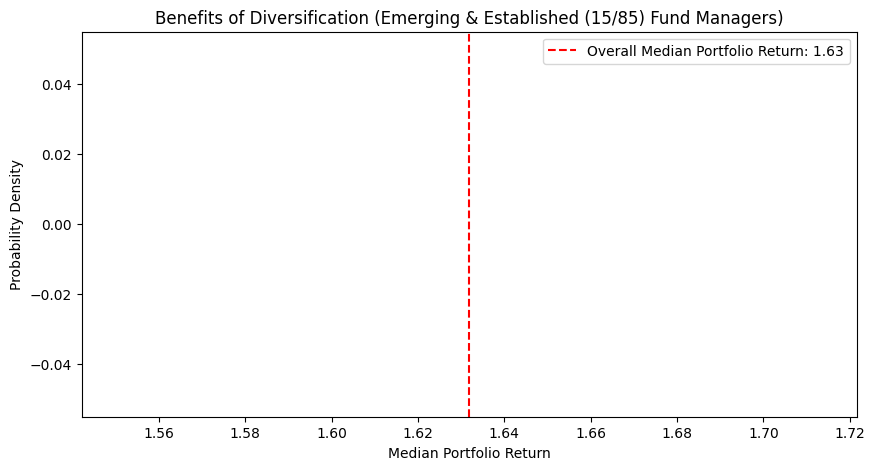

"\nemerging_portfolios, emerging_moic_table = simulate_portfolio_median_returns(\n    emerging_fund_managers,\n    'Emerging'\n)\nestablished_portfolios, established_moic_table = simulate_portfolio_median_returns(\n    established_fund_managers,\n    'Established'\n)\n# Simulate portfolios with a mixture of emerging and established fund managers\nmixed_portfolios, mixed_moic_table = simulate_portfolio_median_returns(\n    data,\n    'Emerging & Established'\n)\n\n\n# Create a mixed dataframe with 30% emerging and 70% established\nmixed_30_70 = create_mixed_dataframe(emerging_fund_managers, established_fund_managers, emerging_num=int(0.3 * 682), established_num=int(0.7 * 682))\nportfolios_30_70, moic_table_30_70 = simulate_portfolio_median_returns(mixed_30_70, 'Emerging & Established (30/70)')\n\n# Create a mixed dataframe with 40% emerging and 60% established\nmixed_40_60 = create_mixed_dataframe(emerging_fund_managers, established_fund_managers, emerging_num=int(0.4 * 682), establishe

In [4]:
"""
emerging_portfolios, emerging_moic_table = simulate_portfolio_median_returns(
    emerging_fund_managers,
    'Emerging'
)
established_portfolios, established_moic_table = simulate_portfolio_median_returns(
    established_fund_managers,
    'Established'
)
# Simulate portfolios with a mixture of emerging and established fund managers
mixed_portfolios, mixed_moic_table = simulate_portfolio_median_returns(
    data,
    'Emerging & Established'
)


# Create a mixed dataframe with 30% emerging and 70% established
mixed_30_70 = create_mixed_dataframe(emerging_fund_managers, established_fund_managers, emerging_num=int(0.3 * 682), established_num=int(0.7 * 682))
portfolios_30_70, moic_table_30_70 = simulate_portfolio_median_returns(mixed_30_70, 'Emerging & Established (30/70)')

# Create a mixed dataframe with 40% emerging and 60% established
mixed_40_60 = create_mixed_dataframe(emerging_fund_managers, established_fund_managers, emerging_num=int(0.4 * 682), established_num=int(0.6 * 682))
portfolios_40_60, moic_table_40_60 = simulate_portfolio_median_returns(mixed_40_60, 'Emerging & Established (40/60)')

# Create a mixed dataframe with 50% emerging and 50% established
mixed_50_50 = create_mixed_dataframe(emerging_fund_managers, established_fund_managers, emerging_num=int(0.5 * 682), established_num=int(0.5 * 682))
portfolios_50_50, moic_table_50_50 = simulate_portfolio_median_returns(mixed_50_50, 'Emerging & Established (50/50)')

# Create a mixed dataframe with 60% emerging and 40% established
mixed_60_40 = create_mixed_dataframe(emerging_fund_managers, established_fund_managers, emerging_num=int(0.6 * 682), established_num=int(0.4 * 682))
portfolios_60_40, moic_table_60_40 = simulate_portfolio_median_returns(mixed_60_40, 'Emerging & Established (60/40)')

# Create a mixed dataframe with 70% emerging and 30% established
mixed_70_30 = create_mixed_dataframe(emerging_fund_managers, established_fund_managers, emerging_num=int(0.7 * 682), established_num=int(0.3 * 682))
portfolios_70_30, moic_table_470_30 = simulate_portfolio_median_returns(mixed_70_30, 'Emerging & Established (70/30)')

# Create a mixed dataframe with 80% emerging and 20% established
mixed_80_20 = create_mixed_dataframe(emerging_fund_managers, established_fund_managers, emerging_num=int(0.8 * 682), established_num=int(0.2 * 682))
portfolios_80_20, moic_table_80_20 = simulate_portfolio_median_returns(mixed_80_20, 'Emerging & Established (80/20)')
"""

In [22]:
mixed_portfolio_df

,FUND ID,FIRM ID,NAME,ASSET CLASS,Vintage,STRATEGY,FINAL CLOSE SIZE (USD MN),NET IRR (%),MOIC,RVPI (%),DPI (%),CALLED (%),PREQIN QUARTILE RANK,QUARTILE RANK,DATE REPORTED,STATUS,FUND MANAGER,CORE INDUSTRIES,MEDIAN BENCHMARK NET IRR (%),MEDIAN BENCHMARK NET MULTIPLE (X),WEIGHTED BENCHMARK NET IRR (%),WEIGHTED BENCHMARK NET MULTIPLE (X),FUND CURRENCY,FUND SIZE (USD MN),FUND NUMBER (SERIES),FUND NUMBER (OVERALL),FUND SERIES NAME,FUND STRUCTURE,PRIMARY REGION FOCUS,FUND AUM (USD MN),FUND DRY POWDER (USD MN),FUND UNREALIZED VALUE (USD MN),FUND LEGAL STRUCTURE,REGION,ADDRESS,CITY,ZIP CODE,TEL,EMAIL,WEBSITE,FUND MANAGER TOTAL AUM (USD MN)
259,16646,45,Ampersand 1994,Venture Capital,1994,Venture (General),15.00,39.90,5.590000,0.000000,559.000000,100.000,2.0,2.0,2023-09-30,Liquidated,Ampersand Capital Partners,Healthcare,27.050000,2.742300,44.618996,6.806752,USD,15.00,2.0,3.0,Ampersand,Commingled,North America,NaN,NaN,NaN,NaN,North America,55 William Street Suite 240,Wellesley,02481,+1 781 239 0700,info@ampersandcapital.com,https://ampersandcapital.com/,3000.00
1214,3753,335,Baird Venture Partners I,Venture Capital,2000,Venture (General),30.00,12.30,1.900000,0.000000,190.000000,98.000,1.0,1.0,2023-09-30,Liquidated,Baird Capital Partners,"Healthcare, Information Technology",-0.075000,0.985108,-1.108608,0.996310,USD,30.00,1.0,5.0,Baird Venture Partners,Commingled,North America,NaN,NaN,NaN,NaN,North America,777 East Wisconsin Avenue,Milwaukee,53202,+1 414 765 3500,info@bairdprivateequity.com,http://www.bairdcapital.com,75.00
498,104931,342796,Acrew Fund I,Venture Capital,2019,Early Stage: Seed,250.00,28.60,1.611450,156.543270,4.601727,82.795,2.0,2.0,2023-03-31,Closed,Acrew Capital,Information Technology,20.630146,1.441921,18.794996,1.521833,USD,250.00,1.0,1.0,Acrew Funds,Commingled,North America,367.04,43.01,324.02,Limited Partnership,North America,3004 16th Street Floor 4,San Francisco,94103,+1 650 400 2026,NaN,http://www.acrewcapital.com,NaN
578,85753,201282,Cowin Kaiyuan Growth Venture Fund,Venture Capital,2013,Early Stage: Seed,19.61,26.00,7.470000,576.000000,171.000000,100.000,1.0,1.0,2022-12-31,Closed,Co-Win Ventures,Diversified,17.621574,2.783900,16.413906,2.965588,RMB,19.61,1.0,3.0,NaN,Commingled,Asia,112.97,0.00,112.97,Limited Partnership,Asia,"Unit 202, Building 13, No.183, Suhong East Roa...",Suzhou,NaN,+86 (0)512 6696 9517,contact@cowinvc.com,http://www.cowinvc.com/,806.80
2854,7467,6712,SEAF Macedonia Fund,Venture Capital,1998,Venture (General),10.40,NaN,1.000000,0.000000,100.000000,90.000,3.0,3.0,2023-09-30,Liquidated,SEAF,Diversified,6.000000,1.221000,5.275588,1.056058,USD,10.40,1.0,3.0,SEAF Macedonia Funds,Commingled,Europe,NaN,NaN,NaN,Limited Liability Company,North America,1500 K Street NW Suite 375,Washington,20005,+1 202 450 1630,contactus@seaf.com,http://www.seaf.com,116.00
2344,436,152,Centennial Fund VI,Venture Capital,1999,Venture (General),400.00,-14.30,0.216000,0.000000,21.600000,95.000,4.0,4.0,2023-09-30,Liquidated,Centennial Ventures,Telecoms & Media,-4.650000,0.659585,-4.871851,0.759195,USD,400.00,6.0,7.0,Centennial Funds,Commingled,North America,NaN,NaN,NaN,NaN,North America,10901 West Toller Drive Suite 206,Littleton,80127,+1 303 405 7500,NaN,http://www.centennial.com,NaN
19,1659,664,Sequoia Capital VII,Venture Capital,1996,Early Stage,150.00,167.44,16.683912,10.326333,1658.064900,100.000,NaN,NaN,2008-06-30,Liquidated,Sequoia Capital,Information Technology,NaN,NaN,NaN,NaN,USD,150.00,7.0,6.0,Sequoia Capital US Venture Funds,Commingled,North America,NaN,NaN,NaN,NaN,North America,2800 Sand Hill Road Suite 101,Menlo Park,94025,+1 650 854 3927,NaN,http://www.sequoiacap.com,85513.00
2036,104553,10551,MRCF5,Venture Capital,2019,Early Stage,175.32,-2.11,0.965000,96.000000,0.500000,57.200,4.0,NaN,2023-06-30,Closed,Brandon Capital Partners,Healthcare,28.440000,1.817011,24.735231,1.621262,AUD,175.32,5.0,7.0,Brandon Capital Partners Funds,Commingled,Australasia,171.31,75.04,96.27,Unit Trust,Australasia,Level 9 31 Queen 

In [57]:
from scipy.stats import norm

def simulate_portfolio_metrics(data, returns_column, vintage_column, manager_type, n_assets=15, n_portfolios=1000, max_iterations=50, risk_free_rate=0.05):
    """
    Simulate portfolio metrics (median return, Sortino ratio, expected shortfall) based on specified conditions.

    Parameters:
    - data: DataFrame containing the dataset.
    - returns_column: Column index or name containing the returns data.
    - vintage_column: Column index or name containing the vintage information.
    - manager_type: A string indicating the type of fund manager (e.g., 'emerging', 'developing', 'established').
    - n_assets: Number of funds in each portfolio.
    - n_portfolios: Number of portfolios to simulate.
    - max_iterations: Maximum iterations for sampling portfolios.
    - risk_free_rate: Risk-free rate for calculating Sortino ratio.

    Returns:
    - portfolio_metrics: DataFrame containing portfolio metrics.
    """

    returns = data.iloc[:, returns_column]

    # Initialize empty lists to store portfolio metrics
    portfolio_median_performances = []
    portfolio_sortino_ratios = []
    portfolio_expected_shortfalls = []

    # Simulate portfolios with tqdm progress bar
    for _ in tqdm(range(n_portfolios), desc=f"Simulating Portfolios ({manager_type})", unit="portfolio"):
        # Sort vintages in ascending order and sample from the first n_assets
        sorted_vintages = data[vintage_column].sort_values().unique()
        selected_assets = np.random.choice(returns.index.dropna(), n_assets, replace=False)
        
        # Check if vintages are no more than 3 years apart
        selected_vintages = data.loc[selected_assets, vintage_column]
        vintage_condition = (selected_vintages.max() - selected_vintages.min()) <= 3
        
        # Continue sampling until the vintage condition is met (with a limit to iterations)
        iterations = 0
        while not vintage_condition and iterations < max_iterations:
            selected_assets = np.random.choice(returns.index.dropna(), n_assets, replace=False)
            selected_vintages = data.loc[selected_assets, vintage_column]
            vintage_condition = (selected_vintages.max() - selected_vintages.min()) <= 3
            iterations += 1

        # Calculate the portfolio's median return directly from the selected assets
        weights = np.ones(n_assets) / n_assets
        portfolio_median_return = np.dot(weights, returns[selected_assets])

        # Calculate downside deviation for Sortino ratio
        downside_returns = np.minimum(returns[selected_assets] - risk_free_rate, 0)
        downside_deviation = np.sqrt(np.mean(downside_returns**2))

        # Calculate Sortino ratio
        if downside_deviation != 0:
            sortino_ratio = (portfolio_median_return - risk_free_rate) / downside_deviation
        else:
            sortino_ratio = np.nan

        # Calculate expected shortfall at 95%
        alpha = 0.05
        es_95 = -np.percentile(returns[selected_assets], alpha * 100)

        # Append metrics to lists
        portfolio_median_performances.append(portfolio_median_return)
        portfolio_sortino_ratios.append(sortino_ratio)
        portfolio_expected_shortfalls.append(es_95)

    # Create a DataFrame for tabulation
    portfolio_metrics = pd.DataFrame({
        'Median Portfolio Return': portfolio_median_performances,
        'Sortino Ratio': portfolio_sortino_ratios,
        'Expected Shortfall (95%)': portfolio_expected_shortfalls
    })

    print(f"Portfolio Metrics for {manager_type} Fund Managers:")
    print(portfolio_metrics.describe())

    return portfolio_metrics

emerging_metrics = simulate_portfolio_metrics(emerging_fund_managers, 8, 'Vintage', 'Emerging', n_assets=15, n_portfolios=1000, max_iterations=50)

Simulating Portfolios (Emerging): 100%|█████████████████████████████████████| 1000/1000 [00:15<00:00, 64.52portfolio/s]

Portfolio Metrics for Emerging Fund Managers:
       Median Portfolio Return  Sortino Ratio  Expected Shortfall (95%)
count              1000.000000     129.000000               1000.000000
mean                  1.963560     248.362334                 -0.532726
std                   0.501817     164.364369                  0.240907
min                   1.015664      83.850530                 -1.349114
25%                   1.603036     148.622773                 -0.698900
50%                   1.879454     183.061443                 -0.522459
75%                   2.233195     290.428715                 -0.367200
max                   4.365678    1025.311565                 -0.000000
